# Visualize registration loss landscapes

TODO: 
- update plot stylings: https://dawes.wordpress.com/2014/06/27/publication-ready-3d-figures-from-matplotlib/
- try widening the basins

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from tqdm import tqdm

from src import read_dicom, Detector, Siddon
from src.metrics import xcorr2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Utility functions for the simulation

- Generate ground truth DRR
- Function for generating estimated DRRs
- Functions for scoring (Negative NCC and L2-norm)

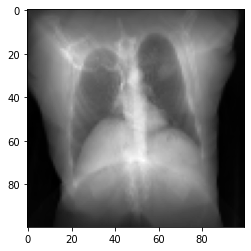

In [2]:
# DRR utility functions
volume, spacing = read_dicom("../data/cxr/")
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)

def make_drr(theta, phi, gamma, bx, by, bz, sdr=200., height=100, delx=10.):
    """Detector parameters -> DRR"""
    detector = Detector(
        sdr    = sdr,
        theta  = theta,
        phi    = phi,
        gamma  = gamma,
        bx     = bx,
        by     = by,
        bz     = bz,
        device = device
    )
    source, rays = detector.make_xrays(height, height, delx, delx)
    drr = siddon.raytrace(source, rays)
    return drr

def plot(drr):
    plt.imshow(drr.detach().cpu(), cmap="gray")
    plt.show()    

# Get the ground truth DRR
theta = torch.pi
phi = 0
gamma = torch.pi / 2
bx = 180
by = 180
bz = 166.25

drr = make_drr(theta, phi, gamma, bx, by, bz)
plot(drr)

In [3]:
# Scoring functions
def get_normxcorr2(theta, phi, gamma, bx, by, bz):
    est = make_drr(theta, phi, gamma, bx, by, bz)
    return corr(drr, est)

def corr(drr, est):
    x = xcorr2()
    loss = x(drr.expand(1, 1, -1, -1), est.expand(1, 1, -1, -1)).item()
    return loss

## Negative Normalized XCorr

In [4]:
# NCC for the XYZs
xs = torch.arange(-15., 16.)
ys = torch.arange(-15., 16.)
zs = torch.arange(-15., 16.)

# Get coordinate-wise correlations
xy_corrs = []
for x in tqdm(xs):
    for y in ys:
        xcorr = get_normxcorr2(theta, phi, gamma, bx+x, by+y, bz)
        xy_corrs.append(-xcorr)
XY = torch.tensor(xy_corrs).reshape(len(xs), len(ys))
        
xz_corrs = []
for x in tqdm(xs):
    for z in zs:
        xcorr = get_normxcorr2(theta, phi, gamma, bx+x, by, bz+z)
        xz_corrs.append(-xcorr)
XZ = torch.tensor(xz_corrs).reshape(len(xs), len(zs))
        
yz_corrs = []
for y in tqdm(ys):
    for z in zs:
        xcorr = get_normxcorr2(theta, phi, gamma, bx, by+y, bz+z)
        yz_corrs.append(-xcorr)
YZ = torch.tensor(yz_corrs).reshape(len(ys), len(zs))

100%|████████████████████████████████████████████████████████████████| 31/31 [00:14<00:00,  2.18it/s]


In [5]:
# NCC for the angles
t_angles = torch.arange(-torch.pi/4, torch.pi/4, step=.05)
p_angles = torch.arange(-torch.pi/4, torch.pi/4, step=.05)
g_angles = torch.arange(-torch.pi/8, torch.pi/8, step=.05)

# Get coordinate-wise correlations
tp_corrs = []
for t in tqdm(t_angles):
    for p in p_angles:
        xcorr = get_normxcorr2(theta+t, phi+p, gamma, bx, by, bz)
        tp_corrs.append(-xcorr)
TP = torch.tensor(tp_corrs).reshape(len(t_angles), len(p_angles))
        
tg_corrs = []
for t in tqdm(t_angles):
    for g in g_angles:
        xcorr = get_normxcorr2(theta+t, phi, gamma+g, bx, by, bz)
        tg_corrs.append(-xcorr)
TG = torch.tensor(tg_corrs).reshape(len(t_angles), len(g_angles))
        
pg_corrs = []
for p in tqdm(p_angles):
    for g in g_angles:
        xcorr = get_normxcorr2(theta, phi+p, gamma+g, bx, by, bz)
        pg_corrs.append(-xcorr)
PG = torch.tensor(pg_corrs).reshape(len(p_angles), len(g_angles))

100%|████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.06it/s]


/home/vivekg/vivekg/miniconda3/envs/DiffDRR/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


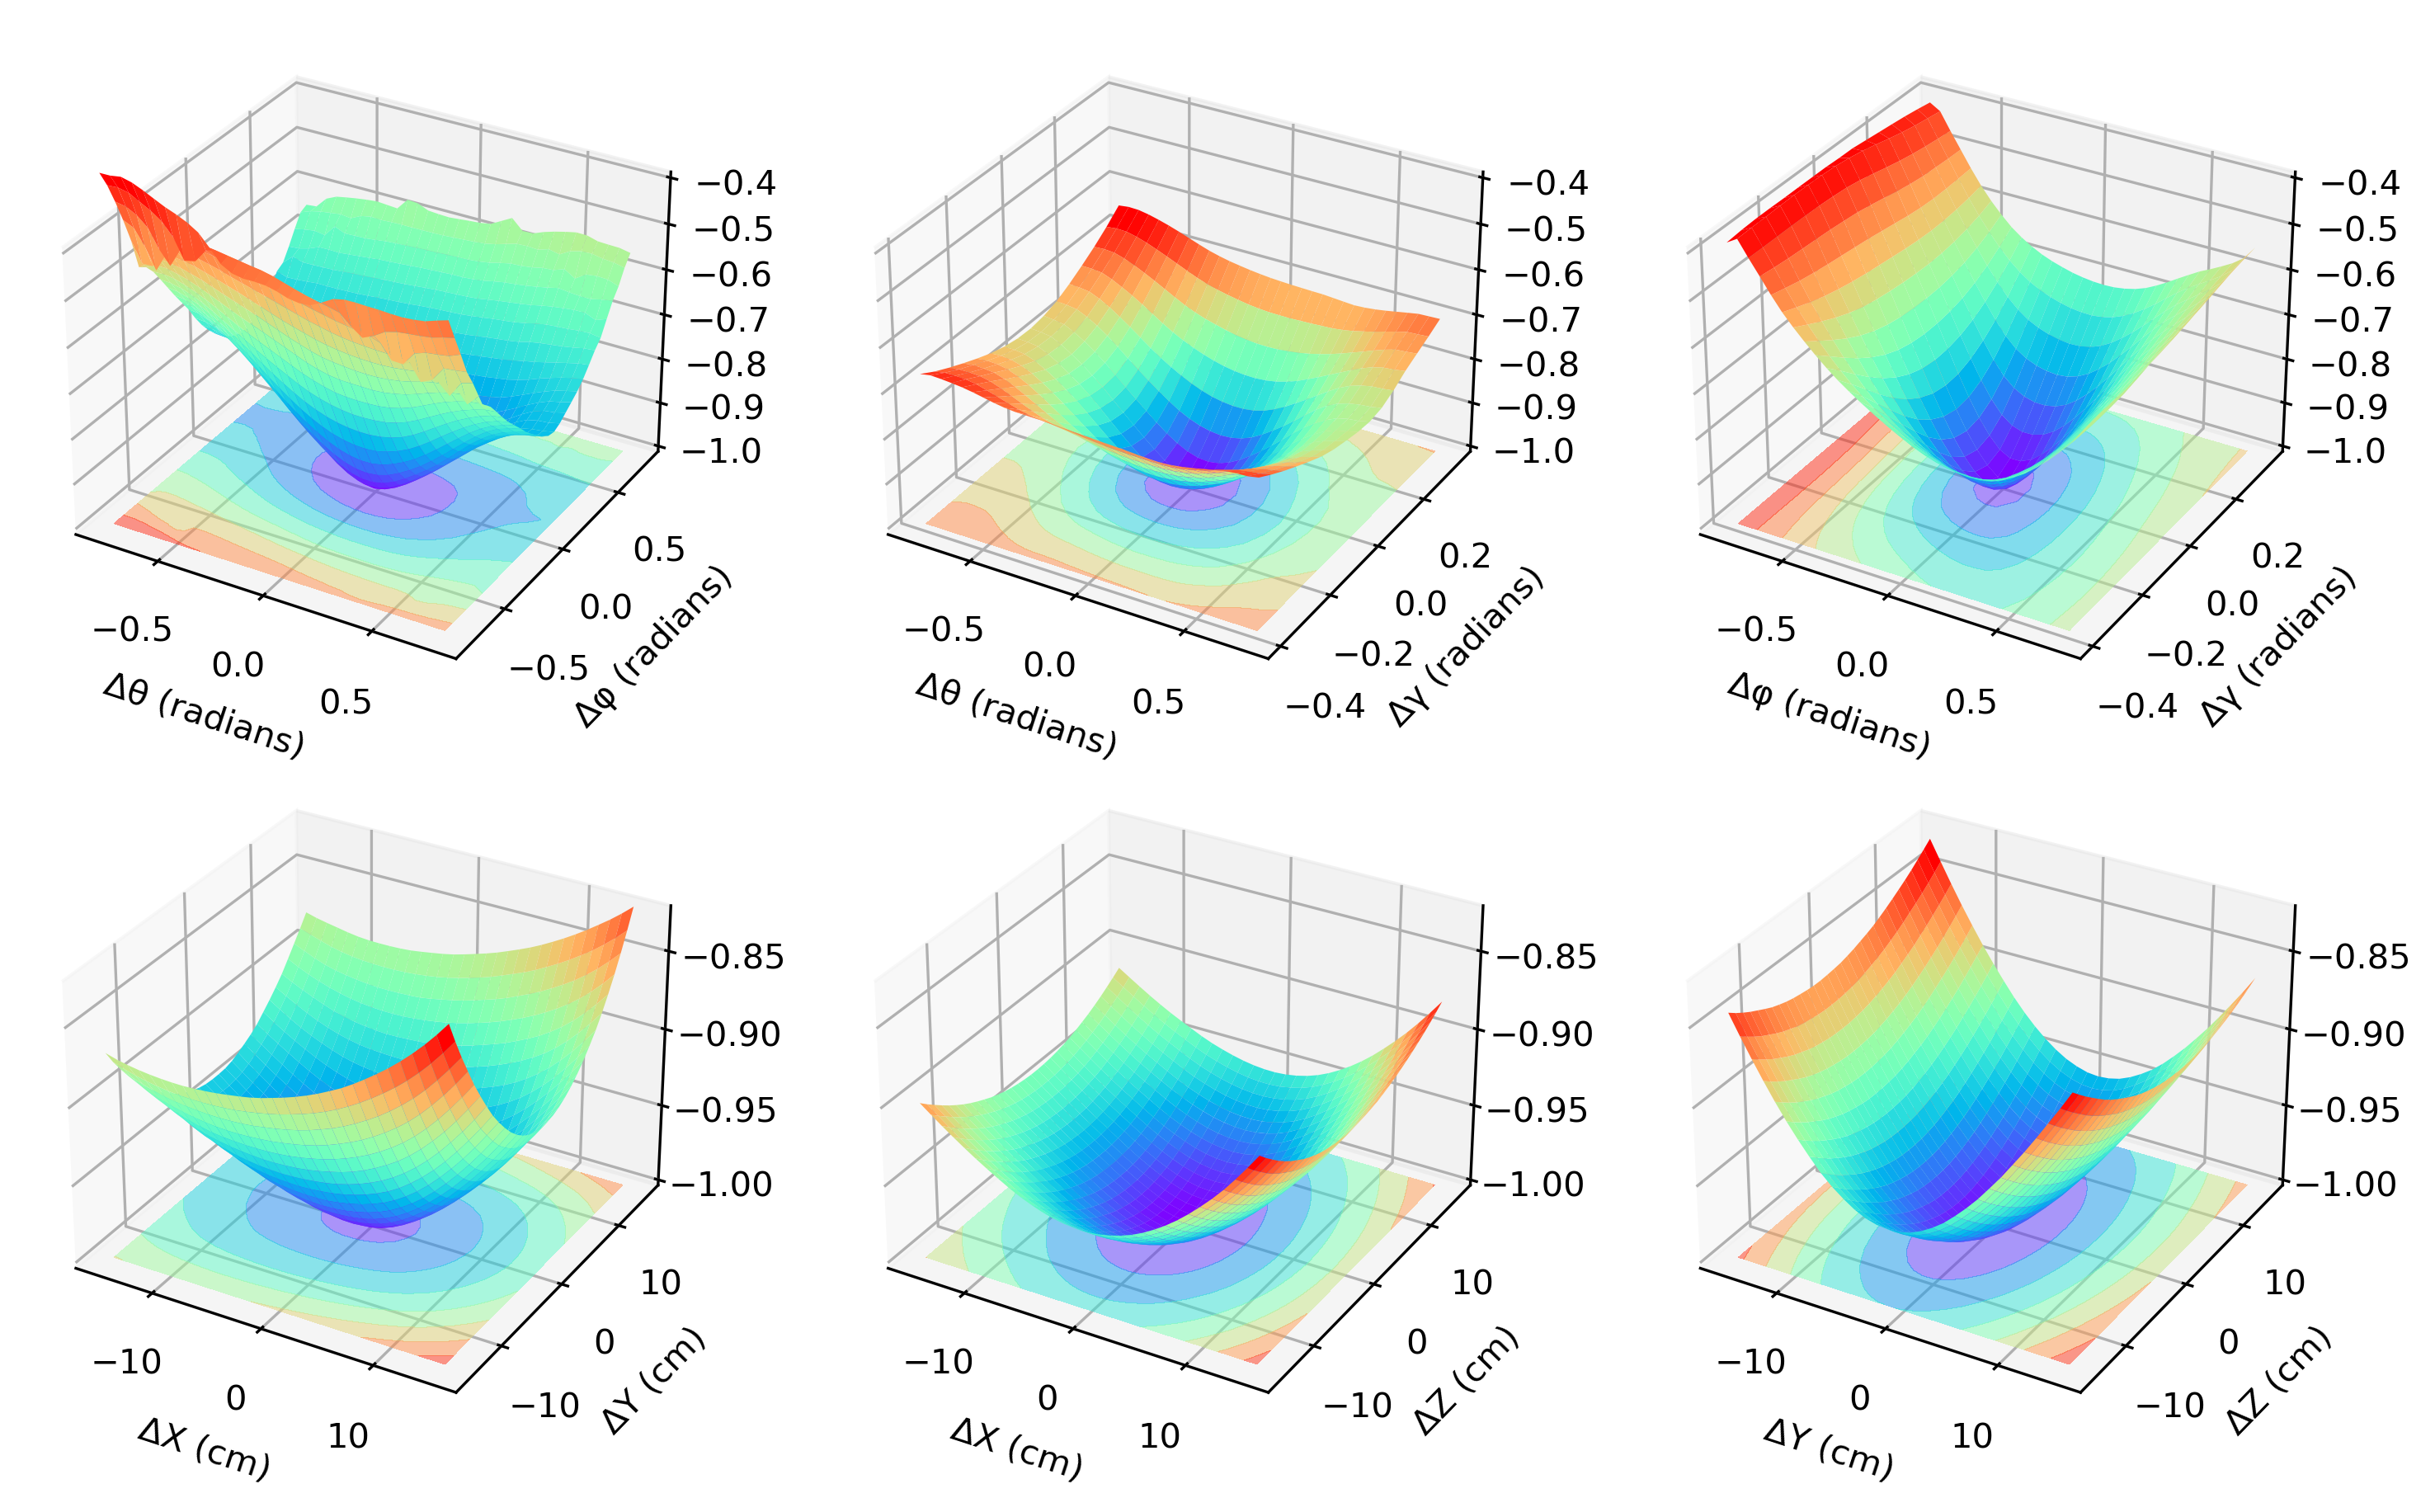

In [7]:
# Make the plots

# XYZ
xyx, xyy = torch.meshgrid(xs, ys)
xzx, xzz = torch.meshgrid(xs, zs)
yzy, yzz = torch.meshgrid(ys, zs)

fig = plt.figure(figsize=3*plt.figaspect(1.2/1), dpi=300)

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.contourf(xyx, xyy, XY, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xyx, xyy, XY, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔX (cm)')
ax.set_ylabel('ΔY (cm)')
ax.set_zlim3d(-1., -0.825)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.contourf(xzx, xzz, XZ, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xzx, xzz, XZ, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔX (cm)')
ax.set_ylabel('ΔZ (cm)')
ax.set_zlim3d(-1., -0.825)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.contourf(yzy, yzz, YZ, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(yzy, yzz, YZ, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔY (cm)')
ax.set_ylabel('ΔZ (cm)')
ax.set_zlim3d(-1., -0.825)


# Angles
xyx, xyy = torch.meshgrid(t_angles, p_angles)
xzx, xzz = torch.meshgrid(t_angles, g_angles)
yzy, yzz = torch.meshgrid(p_angles, g_angles)

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.contourf(xyx, xyy, TP, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xyx, xyy, TP, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('Δθ (radians)')
ax.set_ylabel('Δφ (radians)')
ax.set_zlim3d(-1., -0.4)

ax = fig.add_subplot(2, 3, 2, projection='3d')
ax.contourf(xzx, xzz, TG, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xzx, xzz, TG, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('Δθ (radians)')
ax.set_ylabel('Δγ (radians)')
ax.set_zlim3d(-1., -0.4)

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.contourf(yzy, yzz, PG, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(yzy, yzz, PG, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('Δφ (radians)')
ax.set_ylabel('Δγ (radians)')
ax.set_zlim3d(-1., -0.4)

plt.savefig("../figures/loss_nncc.pdf")
plt.show()